# Метрики (инструмент построения сводной таблицы)

In [3]:
import pandas as pd
import numpy as np

from abc import ABC
from IPython.display import HTML
import warnings
from numbers import Number
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# fairness library
import aif360.sklearn.metrics as aif
import fairlearn.metrics as fl
import sklearn.metrics as sk
from aif360.metrics import ClassificationMetric
from aif360.datasets import StandardDataset
from fairml import audit_model
from fairml import plot_dependencies

from typing import List, Tuple, Type, Union, Callable
ArrayLike = Type[Union[List, Tuple, np.ndarray, pd.Series, pd.DataFrame]]

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib notebook

#### Базовые метрики

In [4]:
def binary_prediction_results(y_true: ArrayLike, y_pred: ArrayLike):
    tn, fp, fn, tp = sk_metric.confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    counts = {"TP": tp, "FP": fp, "TN": tn, "FN": fn}
    return counts

def epsilon():
    return np.finfo(np.float64).eps

# Проверяет, находится ли результат в ожидаемом диапазоне для метрики и возвращает этот результат, если он действителен
def check_result(res: Number, metric_name: str, custom_lower: Number = None, custom_upper: Number = None,):
    if np.isnan(res):
        return res
    else:
        lower = 0 - 100 * epsilon() if custom_lower is None else custom_lower
        upper = 1 + 100 * epsilon() if custom_upper is None else custom_upper
        if not lower < res < upper:
            raise ValueError(f"{metric_name} result out of range ({res})")
        else:
            return res

# возвращает соотношение (исключая деление на ноль)
def ratio(numerator: Number, denominator: Number):
    if denominator == 0:
        return numerator / epsilon()
    else:
        return numerator / denominator


""" Метрики """

# accuracy
def accuracy(y_true: ArrayLike, y_pred: ArrayLike):
    rprt = binary_prediction_results(y_true, y_pred)
    res = ratio(rprt["TP"] + rprt["TN"], y_true.shape[0])
    return check_result(res, "Accuracy")

# balanced accuracy
def balanced_accuracy(y_true: ArrayLike, y_pred: ArrayLike):
    sens = true_positive_rate(y_true, y_pred)
    spec = true_negative_rate(y_true, y_pred)
    res = ratio(sens + spec, 2)
    return check_result(res, "Balanced Accuracy")

# false negative rate
def false_negative_rate(y_true: ArrayLike, y_pred: ArrayLike):
    rprt = binary_prediction_results(y_true, y_pred)
    res = ratio(rprt["FN"], rprt["FN"] + rprt["TP"])
    return check_result(res, "FNR")

# false positive rate
def false_positive_rate(y_true: ArrayLike, y_pred: ArrayLike):
    rprt = binary_prediction_results(y_true, y_pred)
    res = ratio(rprt["FP"], rprt["FP"] + rprt["TN"])
    return check_result(res, "FPR}")

# F1 Score
def f1_score(y_true: ArrayLike, y_pred: ArrayLike):
    pre = precision(y_true, y_pred)
    rec = true_positive_rate(y_true, y_pred)
    res = 2 * ratio(pre * rec, pre + rec)
    return check_result(res, "F1 Score")

#TN/(TN+FN)
def negative_predictive_value(y_true: ArrayLike, y_pred: ArrayLike):
    rprt = binary_prediction_results(y_true, y_pred)
    res = ratio(rprt["TN"], rprt["TN"] + rprt["FN"])
    return res

#Receiver Operating Characteristic Area Under the Curve
def roc_auc_score(y_true: ArrayLike, y_pred: ArrayLike):
    try:
        res = sk_metric.roc_auc_score(y_true, y_pred)
    except ValueError:
        res = 0
    return check_result(res, "ROC AUC Score")

#Precision-Recall Area Under the Curve
def pr_auc_score(y_true: ArrayLike, y_pred: ArrayLike):
    try:
        prc, rec, _ = sk_metric.precision_recall_curve(y_true, y_pred)
        res = sk_metric.auc(prc, rec)
    except ValueError:
        res = np.nan
    return check_result(res, "PR AUC Score")

#PPV=TP/(TP+FP)
def precision(y_true: ArrayLike, y_pred: ArrayLike):
    rprt = binary_prediction_results(y_true, y_pred)
    res = ratio(rprt["TP"], rprt["TP"] + rprt["FP"])
    return check_result(res, "Precision")

#TN/(TN+FP)
def true_negative_rate(y_true: ArrayLike, y_pred: ArrayLike):
    rprt = binary_prediction_results(y_true, y_pred)
    res = ratio(rprt["TN"], rprt["FP"] + rprt["TN"])
    return check_result(res, "TNR")

#TP/(TP+FN)
def true_positive_rate(y_true: ArrayLike, y_pred: ArrayLike):
    rprt = binary_prediction_results(y_true, y_pred)
    res = ratio(rprt["TP"], rprt["FN"] + rprt["TP"])
    return check_result(res, "TPR")

# Обертывает функции отношения, чтобы возвращать значения NaN вместо 0,0 в случаях где отношение не определено
def __manage_undefined_ratios(func: Callable):
    def wrapper(*args, **kwargs):
        funcname = getattr(func, "__name__", "an unknown function")
        msg = (
            "The ratio is ill-defined and being set to 0.0 because"
            + f" '{funcname}' for privileged samples is 0."
        )
        with catch_warnings(record=True) as w:
            filterwarnings("ignore", message=msg)
            res = func(*args, **kwargs)
        if len(w) > 0:
            return np.nan
        else:
            return res

    return wrapper

    #y_true (pd.Series): истинные целевые значения
    #y_pred (pd.Series): прогнозируемые целевые значения
    #prtc_attr (str): имя защищенного атрибута
    #priv_grp (int, optional): привилегированная группа

# Возвращает межгрупповое соотношение Postive Predictive Values
@__manage_undefined_ratios
def ppv_ratio(y_true: pd.Series, y_pred: pd.Series, pa_name: str, priv_grp: int = 1):
    return ratio(precision, y_true, y_pred, prot_attr=pa_name, priv_group=priv_grp)

# Возвращает межгрупповое соотношение True Positive Rates
@__manage_undefined_ratios
def tpr_ratio(y_true: pd.Series, y_pred: pd.Series, pa_name: str, priv_grp: int = 1):
    return ratio(true_positive_rate, y_true, y_pred, prot_attr=pa_name, priv_group=priv_grp)

# Возвращает межгрупповое соотношение False Positive Rates
@__manage_undefined_ratios
def fpr_ratio(y_true: pd.Series, y_pred: pd.Series, pa_name: str, priv_grp: int = 1):
    return ratio(false_positive_rate, y_true, y_pred, prot_attr=pa_name, priv_group=priv_grp)

# Возвращает межгрупповое соотношение True Negative Rates
@__manage_undefined_ratios
def tnr_ratio(y_true: pd.Series, y_pred: pd.Series, pa_name: str, priv_grp: int = 1):
    return ratio(true_negative_rate, y_true, y_pred, prot_attr=pa_name, priv_group=priv_grp)

# Возвращает межгрупповое соотношение False Negative Rates
@__manage_undefined_ratios
def fnr_ratio(y_true: pd.Series, y_pred: pd.Series, pa_name: str, priv_grp: int = 1):
    return ratio(false_negative_rate, y_true, y_pred, prot_attr=pa_name, priv_group=priv_grp)

# Возвращает разницу между группами True Positive Rates
def tpr_diff(y_true: pd.Series, y_pred: pd.Series, pa_name: str, priv_grp: int = 1):
    return difference(true_positive_rate, y_true, y_pred, prot_attr=pa_name, priv_group=priv_grp)

# Возвращает разницу между группами False Positive Rates
def fpr_diff(y_true: pd.Series, y_pred: pd.Series, pa_name: str, priv_grp: int = 1):
    return difference(false_positive_rate, y_true, y_pred, prot_attr=pa_name, priv_group=priv_grp)

# Возвращает разницу между группами True Negative Rates
def tnr_diff(y_true: pd.Series, y_pred: pd.Series, pa_name: str, priv_grp: int = 1):
    return difference(true_negative_rate, y_true, y_pred, prot_attr=pa_name, priv_group=priv_grp)

# Возвращает разницу между группами False Negative Rates
def fnr_diff(y_true: pd.Series, y_pred: pd.Series, pa_name: str, priv_grp: int = 1):
    return difference(false_negative_rate, y_true, y_pred, prot_attr=pa_name, priv_group=priv_grp)


### Основные функции

##### Атрибуты

        X (array-like, pandas DataFrame) - Sample features
        prtc_attr (named array-like) - значения защищенного атрибута
        y_true (одномерный array-like) - истиные значения y
        y_pred (одномерный array-like) - предсказанные значения y
        y_prob (одномерный array-like, optional) - Примеры целевых вероятностей (None)

In [5]:
# вывод ошибки
class valid_error(Exception):
    pass

# Форматирует данные для использования функциями
def format_input(X, prtc_attr, y_true, y_pred, y_prob=None):
    # Проверка входных данных
    valid_data_types = (pd.DataFrame, pd.Series, np.ndarray)
    for data in [X, prtc_attr, y_true, y_pred]:
        if not isinstance(data, valid_data_types):
            raise TypeError("Неверный тип")
        if not data.shape[0] > 1:
            raise ValueError("Введенные данные слишком маленькие для измерения")
    if y_prob is not None:
        if not isinstance(y_prob, valid_data_types):
            raise TypeError("y_prob неверный тип")
          
    # Форматирование входных данных в требуемые типы данных
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    if isinstance(prtc_attr, (np.ndarray, pd.Series)):
        if isinstance(prtc_attr, pd.Series):
            prtc_attr = pd.DataFrame(prtc_attr, columns=[prtc_attr.name])
        else:
            prtc_attr = pd.DataFrame(prtc_attr)
    if isinstance(y_true, (np.ndarray, pd.Series)):
        y_true = pd.DataFrame(y_true)
    if isinstance(y_pred, np.ndarray):
        y_pred = pd.DataFrame(y_pred)
    if isinstance(y_prob, np.ndarray):
        y_prob = pd.DataFrame(y_prob)
    for data in [y_true, y_pred, y_prob]:
        if data is not None and data.shape[1] > 1:
            raise TypeError("y_true, y_pred должны быть одномерным массивом")

    # конфиденциальные атрибуты в качестве индекса для кадров данных y
    pa_name = prtc_attr.columns.tolist()
    prtc_attr.reset_index(inplace=True, drop=True)
    y_true = pd.concat([prtc_attr, y_true.reset_index(drop=True)], axis=1).set_index(pa_name)
    y_pred = pd.concat([prtc_attr, y_pred.reset_index(drop=True)], axis=1).set_index(pa_name)
    y_pred.columns = y_true.columns
    if y_prob is not None:
        y_prob = pd.concat([prtc_attr, y_prob.reset_index(drop=True)],axis=1).set_index(pa_name)
        y_prob.columns = y_true.columns

    # Защищенные атрибуты имеют целочисленное значение
    pa_cols = prtc_attr.columns.tolist()
    for c in pa_cols:
        binary = (set(prtc_attr[c].astype(int)) == set(prtc_attr[c]))
        boolean = (prtc_attr[c].dtype == bool)
        two_valued = (set(prtc_attr[c].astype(int)) == {0,1})
        if not two_valued and (binary or boolean):
            raise ValueError("prtc_attr должен быть бинарным или логическим")
        prtc_attr.loc[:, c] = prtc_attr[c].astype(int)
        if isinstance(c, int):
            prtc_attr.rename(columns={c: f"prtc_attribute_{c}"}, inplace=True)

    return (X, prtc_attr, y_true, y_pred, y_prob)

# Групповые метрики (возвращает словарь с ключом и значениями метрики)
def group_fairness(X, prtc_attr, y_true, y_pred, y_prob=None, priv_grp=1):
    pa_names = prtc_attr.columns.tolist()
    # Список групповых мер справедливости
    group_vals = {}
    group_key = 'Group Fairness'
    
    group_vals['Equal Opportunity Difference'] = aif.equal_opportunity_difference(y_true, y_pred, prot_attr=pa_names)
    group_vals['Statistical Parity Difference'] = aif.statistical_parity_difference(y_true, y_pred, prot_attr=pa_names)
    group_vals['Average Odds Difference'] = aif.average_odds_difference(y_true, y_pred, prot_attr=pa_names)
    group_vals['Disparate Impact Ratio'] = aif.disparate_impact_ratio(y_true, y_pred, prot_attr=pa_names)
    
    if not len(pa_names) > 1:
        group_vals['Equal Odds Difference'] = fl.equalized_odds_difference(y_true, y_pred,sensitive_features=prtc_attr)
        group_vals['Equal Odds Ratio'] = fl.equalized_odds_ratio(y_true, y_pred,sensitive_features=prtc_attr)
        group_vals['Demographic Parity Ratio'] = fl.demographic_parity_ratio(y_true, y_pred,sensitive_features=prtc_attr)
    
    group_vals['Positive Predictive Parity Difference'] = aif.difference(sk.precision_score, y_true, y_pred, prot_attr=pa_names, priv_group=priv_grp)
    group_vals['Balanced Accuracy Difference'] = aif.difference(sk.balanced_accuracy_score, y_true, y_pred, prot_attr=pa_names, priv_group=priv_grp)
        
    return (group_key, group_vals)

# Индивидуальные метрики (возвращает словарь с ключом и значениями метрики)
def individual_fairness(X, prtc_attr, y_true, y_pred):
    pa_names = prtc_attr.columns.tolist()

    b = 1 + y_pred - y_true
    
    # Список индивидуальных мер справедливости
    ind_vals = {}
    ind_key = 'Individual Fairness'
    ind_vals['Consistency Score'] = aif.consistency_score(X, y_pred.iloc[:, 0])
    ind_vals['Generalized Entropy'] = aif.generalized_entropy_index(b)[0]
    ind_vals['Generalized Entropy Error'] = aif.generalized_entropy_error(y_true, y_pred)[0]
    ind_vals['Theil Index'] = aif.theil_index(b)[0]
    ind_vals['Coefficient of Variation'] = aif.coefficient_of_variation(b)[0]
    ind_vals['Between-Group Generalized Entropy Error'] = aif.between_group_generalized_entropy_error(y_true, y_pred,prot_attr=pa_names)
    
    return (ind_key, ind_vals)

# Производительность модели
# Форматирует dataframe отчета о классификации scikit-learn
def classification_performance(y_true, y_pred, target_labels=None):
    if target_labels is None:
        target_labels = [f"target = {t}" for t in set(y_true)]
    report = sk.classification_report(y_true, y_pred, output_dict=True, target_names=target_labels)
    report = pd.DataFrame(report).transpose()
    # Move accuracy to separate row
    accuracy = report.loc['accuracy', :]
    report.drop('accuracy', inplace=True)
    report.loc['accuracy', 'accuracy'] = accuracy[0]
    return(report)

def performance_measures(y_true, y_pred):
    n_class = y_true.append(y_pred).iloc[:, 0].nunique()
    target_labels = [f"target = {t}" for t in set(np.unique(y_true))]
    rprt = classification_performance(y_true.iloc[:, 0], y_pred.iloc[:, 0], target_labels)
    avg_lbl = "weighted avg" if n_class > 2 else target_labels[-1]
    #
    per_vals = {}
    per_key = f'Model Performance'
    for score in ['precision', 'recall', 'f1-score']:
        per_vals[score.title()] = rprt.loc[avg_lbl, score]
    per_vals['Accuracy'] = rprt.loc['accuracy', 'accuracy']
    return (per_key, per_vals)


# возвращает dataframe для построения таблицы
def classification_fairness(X_data, prtc_attr, y_true, y_pred, y_prob=None,priv_grp=1):
    X_data, prtc_attr, y_true, y_pred, y_prob = format_input(X_data, prtc_attr, y_true, y_pred, y_prob)

    n_class = y_true.append(y_pred).iloc[:, 0].nunique()
    if n_class == 2:
        group_key, group_vals = group_fairness(X_data, prtc_attr, y_true, y_pred,y_prob, priv_grp)
    
    ind_key, ind_vals = individual_fairness(X_data, prtc_attr, y_true, y_pred)

    per_key, per_vals = performance_measures(y_true, y_pred)

    # Преобразование оценок в dataframe
    measures = {group_key: group_vals, ind_key: ind_vals, per_key: per_vals}
    df = pd.DataFrame.from_dict(measures, orient="index").stack().to_frame()
    df = pd.DataFrame(df[0].values.tolist(), index=df.index)
    df.columns = ['Value']
    df['Value'] = df.loc[:, 'Value'].round(4)
    df.fillna("", inplace=True)
    return df

# Создает встроенную таблицу стилей html pandas, с выделенными отклоняющимися метриками
# df (pandas dataframe) - dataframe сравнения моделей
def flag_suspicious(df):
    caption = "Fairness Measures"
    #
    idx = pd.IndexSlice
    measures = df.index.get_level_values(1)
    ratios = df.loc[idx['Group Fairness', [c.lower().endswith("ratio") for c in measures]],:].index
    difference = df.loc[idx['Group Fairness',[c.lower().endswith("difference") for c in measures]], :].index

    styled = df.style.set_caption(caption).apply(lambda x: ['color:magenta' if (x.name in ratios and not 0.8 < x.iloc[0] < 1.2) else '' for i in x], axis=1)
    styled.apply(lambda x: ['color:magenta'if (x.name in difference and not -0.1 < x.iloc[0] < 0.1) else '' for i in x], axis=1)
    
    return(HTML(styled.render()))

##### Инструмент сравнения моделей

#### Аргументы
test_data (массив numpy или аналогичный объект pandas)-данные, переданые в модели для генерации прогнозов
target_data (массив numpy или аналогичный объект pandas) - целевой массив данных, соответствующий тестовым данным
protected_attr_data (массив numpy или аналогичный объект pandas) - данные для защищенных атрибутов (двоичные, логические)
models (список) - набор обученных моделей для оценки

In [6]:
class CompareClass(ABC):
    def __init__(self, test_data, target_data, protected_attr_data=None,models=None):
        self.X_data = test_data
        self.protected_attr = protected_attr_data
        self.y = target_data
        self.models = models if models is not None else {}
        self.validate()

    def validation_paused(self):
        if not hasattr(self, "pause_validation"):
            self.pause_validation = False
        return self.pause_validation

    def toggle_validation(self):
        if self.pause_validation:
            self.pause_validation = False
        else:
            self.pause_validation = True
            
    # Проверяет правильность установки атрибутов и обновляет их по мере необходимости
    def validate(self):
        if self.validation_paused():
            return None

        #
        valid_data_types = (pd.DataFrame, pd.Series, np.ndarray)
        for data in [self.X_data, self.y]:
            if not isinstance(data, valid_data_types):
                raise valid_error("Входные данные должны быть массивом numpy или аналогичным объектом pandas")
        if not self.X_data.shape[0] == self.y.shape[0]:
            raise valid_error("Несоответствие тестовых и целевых данных")
        
        # Каждый столбец защищенных атрибутов является логическим?
        if self.protected_attr is not None:
            if not isinstance(self.protected_attr, valid_data_types):
                raise valid_error("Защищенный атрибут(ы) должен быть массивом numpy или аналогичным объектом pandas")
            data_shape = self.protected_attr.shape
            if len(data_shape) > 1 and data_shape[1] > 1:
                raise valid_error("Инструмент не работает с несколькими защищенными атрибутами")
        
        # Модели отображаются как dict?
        if not isinstance(self.models, (dict)) and self.models is not None:
            if not isinstance(self.models, (list, tuple, set)):
                raise valid_error("Неправильный формат переданных моделей")
            self.models = {f'model_{i}': m for i, m in enumerate(self.models)}
            print("Поскольку имена моделей не были переданы, следующие имена",
                  "были присвоены моделям по их индексам:",
                  f"{list(self.models.keys())}")
        
        # Модели присутствуют и имеют функцию прогнозирования?
        if self.models is not None:
            if not len(self.models) > 0:
                raise valid_error("Набор моделей пуст!")
            else:
                for _, m in self.models.items():
                    pred_func = getattr(m, "predict", None)
                    if not callable(pred_func):
                        raise valid_error(f"{m} модель не имеет функции прогнозирования")
        return None

    # dataframe, сравнивающий показатели справедливости для model_name
    def measure_model(self, model_name):
        self.validate()
        if model_name not in self.models.keys():
            print(f"Ошибка измерения справедливости: {model_name} не появляется в", "моделях. Доступные модели включают ", f"{list(self.models.keys())}")
            return pd.DataFrame()
        m = self.models[model_name]
        # Прогнозы могут быть сгенерированы из тестовых данных?
        try:
            y_pred = m.predict(self.X_data)
        except BaseException as e:
            raise valid_error("Ошибка генерации прогнозов для " + f"{model_name}.")
        # Поскольку для большинства показателей справедливости не требуются вероятности (y_prob) - является необязательным
        try:
            y_prob = m.predict_proba(self.X_data)[:, 1]
        except BaseException as e:
            warnings.warn(f"Неудача предсказания вероятностей для {model_name}." + f" Связанные метрики будут пропущены. {e}")
            y_prob = None
        finally:
            res = classification_fairness(self.X_data, self.protected_attr, self.y, y_pred, y_prob)
            return res

# dataframe сравнивающий показатели справедливости для всех доступных моделей
    def compare_measures(self):
        self.validate()
        if len(self.models) == 0:
            print("Нет моделей для сравнения")
            return pd.DataFrame()
        else:
            test_results = []
            # Отключение проверки модели
            self.toggle_validation()
            
            # Результат для каждой модели
            for model_name in self.models.keys():
                res = self.measure_model(model_name)
                res.rename(columns={'Value': model_name}, inplace=True)
                test_results.append(res)
            
            self.toggle_validation()  # проверка модели
            if len(test_results) > 0:
                output = pd.concat(test_results, axis=1)
                return output
            else:
                return None

# Создает отчет, сравнивающий показатели справедливости для переданных моделей
def compare_measures(test_data, target_data, protected_attr_data=None,models=None):
    comp = CompareClass(test_data, target_data, protected_attr_data, models)
    table = comp.compare_measures()
    return(table)

## Тестирование

In [7]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

### Подготовка набора данных

In [5]:
# Обучающие данные
df_train = pd.read_csv("./input/Webpages_Classification_train_data.csv/Webpages_Classification_train_data.csv")
df_train.drop(columns = "Unnamed: 0", inplace = True)

# Тренировачные данные
df_test = pd.read_csv("./input/Webpages_Classification_test_data.csv/Webpages_Classification_test_data.csv")
df_test.drop(columns = "Unnamed: 0", inplace = True)

# Кодировка стран
count = pd.read_csv('./input/tableconvert_csv_pkcsig.csv')

countries = dict(zip(count['Country'], count['Alpha-3 code']))

df_train['iso_3'] = df_train['geo_loc']
df_train['iso_3'].replace(countries, inplace=True)

df_train.https.replace({'yes': 'HTTPS', 'no': 'HTTP'}, inplace=True)


In [6]:
# Создание новых признаков
# Подсчет специальных символов в содержимом
def count_special(string):
    count = 0
    for char in string:
        if not (char.islower()) and not (char.isupper()) and not (char.isdigit()):
            if char != ' ':
                count += 1
    return count


# Определение типа сети [A, B, C]
def network_type(ip):
    ip_str = ip.split(".")
    ip = [int(x) for x in ip_str]

    if ip[0] >= 0 and ip[0] <= 127:
        return (ip_str[0], "A")
    elif ip[0] >= 128 and ip[0] <= 191:
        return (".".join(ip_str[0:2]), "B")
    else:
        return (".".join(ip_str[0:3]), "C")


# Добавление признака с типом сети
df_train['Network'] = df_train['ip_add'].apply(lambda x: network_type(x))
df_train['net_part'], df_train['net_type'] = zip(*df_train.Network)
df_train.drop(columns=['Network'], inplace=True)

# Признак с количеством специальных знаков
df_train['special_char'] = df_train['content'].apply(lambda x: count_special(x))

# Длина признака Content
df_train['content_len'] = df_train['content'].apply(lambda x: len(x))

df_train.label.replace({'bad': 'Malicious', 'good': 'Benign'}, inplace=True)

df_train.label.replace({'Malicious': 1, 'Benign': 0}, inplace=True)

ls = ['geo_loc', 'tld', 'who_is', 'https', 'net_type']
le_dict = {}

for feature in ls:
    le = LabelEncoder()
    le_dict[feature] = le
    df_train[feature] = le.fit_transform(df_train[feature])

# Конечные атрибуты, которые пойду в обучающую выборку
df_train = df_train[
    ['url_len', 'geo_loc', 'tld', 'who_is', 'https', 'js_len', 'js_obf_len', 'label', 'net_type', 'special_char',
     'content_len']]

ss_dict = {}

for feature in ['content_len', 'special_char']:
    ss = StandardScaler()
    ss_fit = ss.fit(df_train[feature].values.reshape(-1, 1))
    ss_dict[feature] = ss_fit
    d = ss_fit.transform(df_train[feature].values.reshape(-1, 1))
    df_train[feature] = pd.DataFrame(d, index=df_train.index, columns=[feature])

In [7]:
df_test.https.replace({'yes' : 'HTTPS', 'no' : 'HTTP'}, inplace = True)
df_test.label.replace({'bad' : 'Malicious', 'good' : 'Benign'}, inplace = True)

df_test['Network']= df_test['ip_add'].apply(lambda x : network_type(x))
df_test['net_part'], df_test['net_type'] = zip(*df_test.Network)
df_test.drop(columns = ['Network'], inplace = True)

df_test['special_char'] = df_test['content'].apply(lambda x: count_special(x))

df_test['content_len'] = df_test['content'].apply(lambda x: len(x))

for feature in ls:
    le = le_dict[feature]
    df_test[feature] = le.fit_transform(df_test[feature])

df_test.label.replace({'Malicious' : 1, 'Benign' : 0}, inplace = True)

ss_fit = ss_dict['content_len']
d = ss_fit.transform(df_test['content_len'].values.reshape(-1, 1))
df_test['content_len'] = pd.DataFrame(d, index = df_test.index, columns = ['content_len'])

ss_fit = ss_dict['special_char']
d = ss_fit.transform(df_test['special_char'].values.reshape(-1, 1))
df_test['special_char'] = pd.DataFrame(d, index = df_test.index, columns = ['special_char'])

df_test = df_test[['url_len', 'geo_loc', 'tld', 'who_is', 'https', 'js_len', 'js_obf_len', 'label', 'net_type', 'special_char', 'content_len']]


### Выбор модели машинного обучения

In [123]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [124]:
classifiers = [
    KNeighborsClassifier(5),
    SVC(probability=True, kernel='rbf'),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    LogisticRegression(solver='lbfgs', max_iter=1000),]

log_cols = ["Classifier", "f1"]
log = pd.DataFrame(columns=log_cols)

acc_dict = {}

for test in classifiers:
    name = test.__class__.__name__
    test.fit(X_train, y_train)
    train_predictions = test.predict(X_test)
    acc = f1_score(y_test, train_predictions)
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc

for test in acc_dict:
    acc_dict[test] = acc_dict[test] / 10.0
    log_entry = pd.DataFrame([[test, acc_dict[test]]], columns=log_cols)
    log = pd.concat([log, log_entry])

print(log)

               Classifier        f1
0    KNeighborsClassifier  0.097575
0                     SVC  0.097599
0  DecisionTreeClassifier  0.098355
0  RandomForestClassifier   0.09931
0              GaussianNB  0.097463
0      LogisticRegression  0.095253


NameError: name 'sns' is not defined

<IPython.core.display.Javascript object>


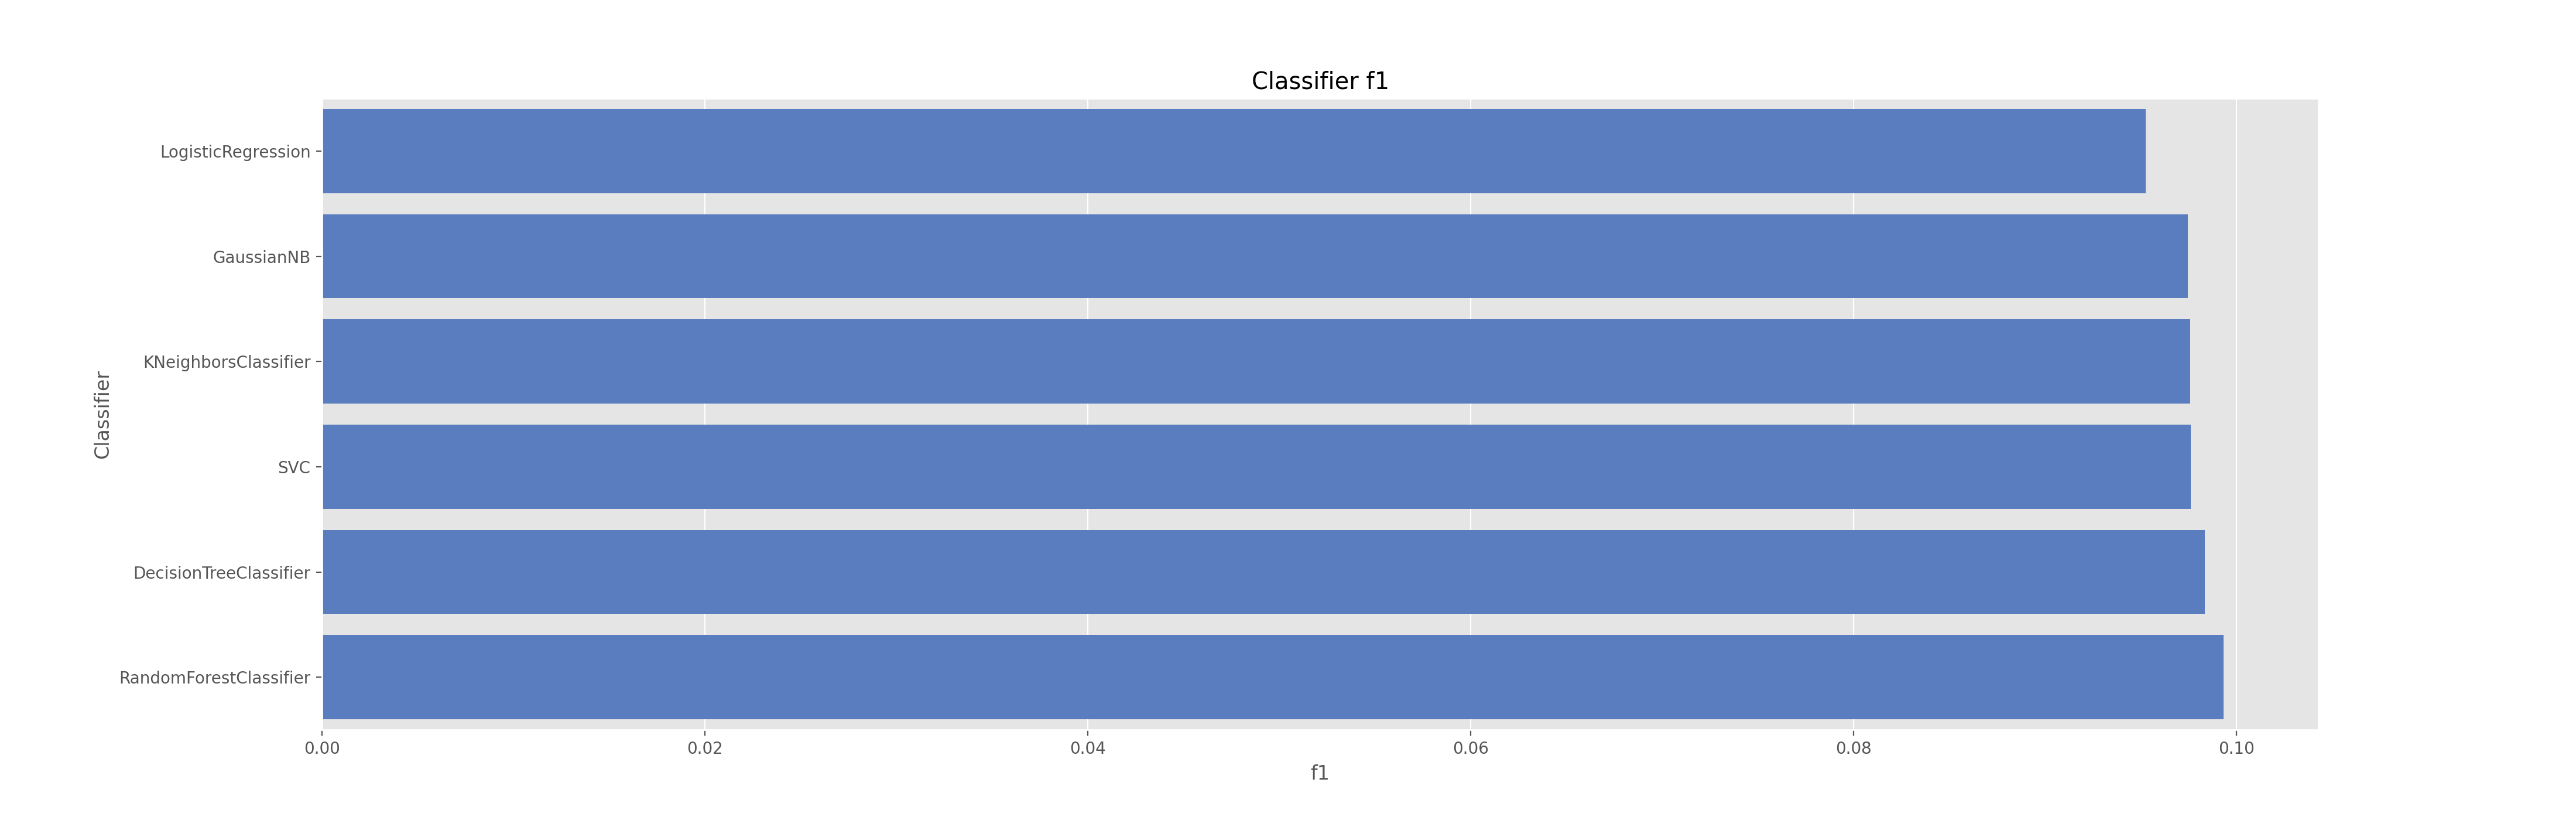

In [129]:
plt.xlabel('f1')
plt.title('Classifier f1')

plt.rcParams['figure.figsize'] = [27, 7]
sns.set_color_codes("muted")
sns.barplot(x='f1', y='Classifier', data=log.sort_values(by='f1'), color="b")
plt.show()

#### Обучение выбранной модели

In [2]:
train= df_train.iloc[:500000,]
test= df_test.iloc[:,]

print(len(train), 'train examples')
print(len(test), 'test examples')

y_train = train['label']
X_train = train.drop(columns=['label'])

y_test = test['label']
X_test = test.drop(columns=['label'])

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

NameError: name 'df_train' is not defined

### Тестирование инстурмента таблиц метрик

In [112]:
model_dict = {'model': clf}
# Deterimine the protected attributes
prtc_attr = X_test['https']
# Pass the above to the compare models function
lin_comp = compare_measures(X_test, y_test, prtc_attr, model_dict)
# Add highlights
flag_suspicious(lin_comp)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


0.9992191946597998
0.00016027835372221103
0.00016027835372221103
0.0002543921048459844
0.02532021751266849
6.194086166354441e-10


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
this method is deprecated in favour of `Styler.to_html()`


### Построение других моделей и их сравнение

#### Неосведомленная модели

In [151]:
train= df_train.iloc[:500000,]
test= df_test.iloc[:,]

y_train = train['label']
X_train = train.drop(columns=['label'])

y_test = test['label']
X_test = test.drop(columns=['label'])

clf_un = RandomForestClassifier()
clf_un.fit(X_train.drop('https', axis=1), y_train)
#y_pred_un = clf_un.predict(X_test)

RandomForestClassifier()

In [152]:
model_dict = {'model': clf_un}
# Deterimine the protected attributes
prtc_attr = X_test['https']
# Pass the above to the compare models function
lin_comp = compare_measures(X_test.drop('https', axis=1), y_test, prtc_attr, model_dict)
# Add highlights
flag_suspicious(lin_comp)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
this method is deprecated in favour of `Styler.to_html()`


#### Справедливая модель

In [ ]:
from fairlearn.reductions import GridSearch, DemographicParity
rf_params = {'n_estimators': 1800, 'min_samples_split': 5, 'bootstrap': False}
# Model using GridSearch to optimize for demographic parity
fairGridSearch = GridSearch(RandomForestClassifier(**rf_params),
                           constraints=DemographicParity(),
                           grid_size=45)


fairGridSearch.fit(X_train, y_train, sensitive_features=X_train['https'])

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Seri

In [158]:
from fairlearn.reductions import ExponentiatedGradient,EqualizedOdds,DemographicParity

eg = ExponentiatedGradient(estimator=clf, constraints=DemographicParity(), max_iter=2)
eg.fit(X_train,y_train, sensitive_features=X_train['https'])

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
The pivot operation produces a pivot value of: 7.2e-06, which is only slightly greater than the specified tolerance 1.0e-09. This may lead to issues regarding the numerical stability of the simplex method. Removing redundant constraints

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x000001DDDEB1AE50>,
                      estimator=RandomForestClassifier(), max_iter=2,
                      nu=1.0000000000015263e-06)

In [1]:
model_dict = {'model': eg}
# Deterimine the protected attributes
prtc_attr = X_test['https']
# Pass the above to the compare models function
lin_comp = compare_measures(X_test, y_test, prtc_attr, model_dict)
# Add highlights
flag_suspicious(lin_comp)

NameError: name 'eg' is not defined

#### Сравнение

In [ ]:
model_dict = {'Random Forest': clf, 'Model 2': clf_un, 'GridSearch': fairGridSearch}

### Использование инструмента FairML

In [121]:
matplotlib.use('Agg')

plt.style.use('ggplot')
plt.figure(figsize=(6, 6))

#  аудит модели
importancies, _ = audit_model(clf.predict, X_test)

# print feature importance
print(importancies)

# generate feature dependence plot
fig = plot_dependencies(
    importancies.median(),
    reverse_values=False,
    title="FairML feature dependence logistic regression model")

file_name = "fairml_propublica_linear_direct.png"
plt.show()
plt.savefig(file_name, transparent=False, bbox_inches='tight', dpi=250)

Feature: url_len,	 Importance: 0.0015803986362154425
Feature: geo_loc,	 Importance: -0.0014284372288870346
Feature: tld,	 Importance: -0.0004282548751982406
Feature: who_is,	 Importance: 0.003362491503975863
Feature: https,	 Importance: -0.00027905640254853093
Feature: js_len,	 Importance: 0.011112523277724669
Feature: js_obf_len,	 Importance: 0.018873606790188267
Feature: net_type,	 Importance: 0.0007321776898550564
Feature: special_char,	 Importance: -0.02215321025380318
Feature: content_len,	 Importance: -0.01850061060856399


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


#### Другое

In [131]:
from fairmlhealth import report, measure, stat_utils
measure.data(X_test, y_test, features=['https', 'who_is'])

,Feature Name,Feature Value,Obs.,Entropy,Mean label,Median label,Missing Values,Std. Dev. label,Value Prevalence
0,ALL FEATURES,ALL VALUES,361934,NaN,0.0223,0.0,0,0.1476,1.0000
1,https,0,78595,0.7549,0.0925,0.0,0,0.2897,0.2172
2,https,1,283339,0.7549,0.0028,0.0,0,0.0529,0.7828
3,who_is,0,283804,0.7526,0.0028,0.0,0,0.0526,0.7841
4,who_is,1,78130,0.7526,0.0931,0.0,0,0.2906,0.2159


In [133]:
measure.data(X_test[['https', 'who_is', 'net_type']], y_test)

,Feature Name,Feature Value,Obs.,Entropy,Mean label,Median label,Missing Values,Std. Dev. label,Value Prevalence
0,ALL FEATURES,ALL VALUES,361934,NaN,0.0223,0.0,0,0.1476,1.0000
1,https,0,78595,0.7549,0.0925,0.0,0,0.2897,0.2172
2,https,1,283339,0.7549,0.0028,0.0,0,0.0529,0.7828
3,who_is,0,283804,0.7526,0.0028,0.0,0,0.0526,0.7841
4,who_is,1,78130,0.7526,0.0931,0.0,0,0.2906,0.2159
5,net_type,0,206103,1.3798,0.0228,0.0,0,0.1492,0.5694
6,net_type,1,104453,1.3798,0.0213,0.0,0,0.1444,0.2886
7,net_type,2,51378,1.3798,0.0222,0.0,0,0.1475,0.1420


In [138]:
measure.performance(X_test[['https']], y_test, clf.predict(X_test))

,Feature Name,Feature Value,Obs.,Mean Target,Mean Prediction,Accuracy,F1-Score,FPR,Precision,TPR
0,ALL FEATURES,ALL VALUES,361934.0,0.0223,0.0222,0.9997,0.9928,0.0001,0.9951,0.9904
1,https,0,78595.0,0.0925,0.0924,0.9990,0.9946,0.0005,0.9948,0.9944
2,https,1,283339.0,0.0028,0.0027,0.9999,0.9762,0.0000,0.9987,0.9547


In [141]:
measure.bias(X_test[['https', 'who_is']], y_test, clf.predict(X_test), flag_oor=True)

this method is deprecated in favour of `Styler.format(precision=..)`


,Feature Name,Feature Value,Balanced Accuracy Difference,Balanced Accuracy Ratio,FPR Diff,FPR Ratio,PPV Diff,PPV Ratio,Selection Diff,Selection Ratio,TPR Diff,TPR Ratio
0,https,0,-0.0196,0.9804,-0.0005,0.0066,0.0039,1.0039,-0.0897,0.0290,-0.0396,0.9601
1,https,1,0.0196,1.0200,0.0005,150.5253,-0.0039,0.9961,0.0897,34.4567,0.0396,1.0415
2,who_is,0,0.0184,1.0188,0.0005,34.9502,0.0005,1.0005,0.0903,34.8706,0.0373,1.0390
3,who_is,1,-0.0184,0.9815,-0.0005,0.0286,-0.0005,0.9995,-0.0903,0.0287,-0.0373,0.9625
